In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import glob
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as op
import torchvision.models as mo
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision import datasets
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import accuracy_score,precision_score,recall_score
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
resnet=mo.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [3]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225])])


In [4]:
dirs=glob.glob("../input/cat-and-dog/training_set/training_set/cats/*")
dirs1=glob.glob("../input/cat-and-dog/training_set/training_set/dogs/*")

In [5]:
imgloader=datasets.ImageFolder("../input/cat-and-dog/training_set/training_set/",transform=transform)

In [6]:
validimgloader=datasets.ImageFolder("../input/cat-and-dog/test_set/test_set/",transform=transform)

In [7]:
dataloader = torch.utils.data.DataLoader(imgloader, batch_size=32, shuffle=True)
# images, labels = next(iter(dataloader))


In [8]:
validdataloader = torch.utils.data.DataLoader(validimgloader, batch_size=32, shuffle=True)

In [9]:
images, labels = next(iter(dataloader))

In [10]:
newmodel=nn.Sequential(*(list(resnet.children())[:-1]))

In [11]:
im=torch.randn((5,3,224,224))

In [12]:
newmodel(im).shape

torch.Size([5, 512, 1, 1])

In [13]:
class newmodel(nn.Module):
    def __init__(self,nclasses):
        super().__init__()
        self.cls=nn.Sequential(*(list(resnet.children())[:-1]))
        self.fc=nn.Linear(512,nclasses)
    
    def forward(self,x):
        return self.fc(self.cls(x).squeeze())

In [14]:
model1=newmodel(2)

In [15]:
opt=op.Adam(model1.parameters(),lr=0.0001)

In [16]:
device=torch.device("cuda:0")

In [17]:
model1=model1.to(device)

In [18]:
trainloss=[]
validationloss=[]
vaccuracy=[]
c=0
for i in tqdm.tqdm(dataloader):
    opt.zero_grad()
    pred=model1(i[0].to(device))
    loss=f.cross_entropy(pred,i[1].to(device))
    loss.backward()
    opt.step()
    trainloss.append(loss.detach().cpu().item())
    print(loss)
    
    if c%10==0:
        print("---------validation_start-----------")
        model1.eval()
        with torch.no_grad():
            j=0
            validloss=[]
            vpred=[]
            vactual=[]
            for m in validdataloader:
                valpred=model1(m[0].to(device))
                vloss=f.cross_entropy(valpred,m[1].to(device))
                validloss.append(vloss.detach().cpu().item())
                vpred.append(valpred.detach().cpu().argmax(-1).numpy())
                vactual.append(m[1].detach().cpu().numpy())
            validationloss.append(sum(validloss)/len(validloss))
            vaccuracy.append(accuracy_score(np.concatenate(vpred),np.concatenate(vactual)))
            del valpred,vloss,vactual
            torch.cuda.empty_cache()
            print("-----------validation_end--------------")
            print("---loss---- ",validationloss[-1])
            print("---validacc---- ",vaccuracy[-1])
    c+=1
    model1.train()

  0%|          | 0/251 [00:00<?, ?it/s]

tensor(0.8487, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


  0%|          | 1/251 [00:23<1:38:01, 23.52s/it]

-----------validation_end--------------
---loss----  0.567484971601516
---validacc----  0.7167572911517548


  1%|          | 2/251 [00:23<41:07,  9.91s/it]  

tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)


  1%|          | 3/251 [00:24<23:00,  5.57s/it]

tensor(0.5313, device='cuda:0', grad_fn=<NllLossBackward>)


  2%|▏         | 4/251 [00:24<14:31,  3.53s/it]

tensor(0.2842, device='cuda:0', grad_fn=<NllLossBackward>)


  2%|▏         | 5/251 [00:25<09:49,  2.39s/it]

tensor(0.2718, device='cuda:0', grad_fn=<NllLossBackward>)


  2%|▏         | 6/251 [00:25<07:09,  1.75s/it]

tensor(0.2682, device='cuda:0', grad_fn=<NllLossBackward>)


  3%|▎         | 7/251 [00:26<05:20,  1.31s/it]

tensor(0.2492, device='cuda:0', grad_fn=<NllLossBackward>)


  3%|▎         | 8/251 [00:26<04:08,  1.02s/it]

tensor(0.1564, device='cuda:0', grad_fn=<NllLossBackward>)


  4%|▎         | 9/251 [00:26<03:19,  1.21it/s]

tensor(0.1344, device='cuda:0', grad_fn=<NllLossBackward>)


  4%|▍         | 10/251 [00:27<02:46,  1.45it/s]

tensor(0.0884, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1155, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


  4%|▍         | 11/251 [00:39<16:48,  4.20s/it]

-----------validation_end--------------
---loss----  0.0867880568257533
---validacc----  0.9703410776075136


  5%|▍         | 12/251 [00:39<12:12,  3.06s/it]

tensor(0.1579, device='cuda:0', grad_fn=<NllLossBackward>)


  5%|▌         | 13/251 [00:40<08:59,  2.27s/it]

tensor(0.0963, device='cuda:0', grad_fn=<NllLossBackward>)


  6%|▌         | 14/251 [00:40<06:46,  1.72s/it]

tensor(0.0714, device='cuda:0', grad_fn=<NllLossBackward>)


  6%|▌         | 15/251 [00:41<05:11,  1.32s/it]

tensor(0.1173, device='cuda:0', grad_fn=<NllLossBackward>)


  6%|▋         | 16/251 [00:41<04:04,  1.04s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLossBackward>)


  7%|▋         | 17/251 [00:41<03:19,  1.17it/s]

tensor(0.1026, device='cuda:0', grad_fn=<NllLossBackward>)


  7%|▋         | 18/251 [00:42<02:47,  1.39it/s]

tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward>)


  8%|▊         | 19/251 [00:42<02:24,  1.60it/s]

tensor(0.0494, device='cuda:0', grad_fn=<NllLossBackward>)


  8%|▊         | 20/251 [00:43<02:08,  1.80it/s]

tensor(0.1423, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0750, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


  8%|▊         | 21/251 [00:55<15:28,  4.04s/it]

-----------validation_end--------------
---loss----  0.07570745881821495
---validacc----  0.9713297083539298


  9%|▉         | 22/251 [00:55<11:16,  2.95s/it]

tensor(0.2283, device='cuda:0', grad_fn=<NllLossBackward>)


  9%|▉         | 23/251 [00:56<08:20,  2.20s/it]

tensor(0.1011, device='cuda:0', grad_fn=<NllLossBackward>)


 10%|▉         | 24/251 [00:56<06:16,  1.66s/it]

tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward>)


 10%|▉         | 25/251 [00:56<04:49,  1.28s/it]

tensor(0.0518, device='cuda:0', grad_fn=<NllLossBackward>)


 10%|█         | 26/251 [00:57<03:48,  1.01s/it]

tensor(0.1008, device='cuda:0', grad_fn=<NllLossBackward>)


 11%|█         | 27/251 [00:57<03:05,  1.21it/s]

tensor(0.0728, device='cuda:0', grad_fn=<NllLossBackward>)


 11%|█         | 28/251 [00:58<02:34,  1.44it/s]

tensor(0.0556, device='cuda:0', grad_fn=<NllLossBackward>)


 12%|█▏        | 29/251 [00:58<02:20,  1.58it/s]

tensor(0.0532, device='cuda:0', grad_fn=<NllLossBackward>)


 12%|█▏        | 30/251 [00:58<02:04,  1.77it/s]

tensor(0.0614, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1209, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 12%|█▏        | 31/251 [01:11<14:50,  4.05s/it]

-----------validation_end--------------
---loss----  0.07426228059193818
---validacc----  0.9698467622343054


 13%|█▎        | 32/251 [01:11<10:50,  2.97s/it]

tensor(0.1250, device='cuda:0', grad_fn=<NllLossBackward>)


 13%|█▎        | 33/251 [01:12<08:01,  2.21s/it]

tensor(0.1786, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▎        | 34/251 [01:12<06:03,  1.68s/it]

tensor(0.1211, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 35/251 [01:12<04:40,  1.30s/it]

tensor(0.1446, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 36/251 [01:13<03:41,  1.03s/it]

tensor(0.2674, device='cuda:0', grad_fn=<NllLossBackward>)


 15%|█▍        | 37/251 [01:13<03:01,  1.18it/s]

tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward>)


 15%|█▌        | 38/251 [01:14<02:33,  1.39it/s]

tensor(0.0125, device='cuda:0', grad_fn=<NllLossBackward>)


 16%|█▌        | 39/251 [01:14<02:12,  1.60it/s]

tensor(0.2422, device='cuda:0', grad_fn=<NllLossBackward>)


 16%|█▌        | 40/251 [01:14<01:58,  1.78it/s]

tensor(0.0470, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0683, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 16%|█▋        | 41/251 [01:26<13:48,  3.95s/it]

-----------validation_end--------------
---loss----  0.06159716673209914
---validacc----  0.9777558082056352


 17%|█▋        | 42/251 [01:27<10:05,  2.90s/it]

tensor(0.1017, device='cuda:0', grad_fn=<NllLossBackward>)


 17%|█▋        | 43/251 [01:27<07:34,  2.18s/it]

tensor(0.0696, device='cuda:0', grad_fn=<NllLossBackward>)


 18%|█▊        | 44/251 [01:28<05:45,  1.67s/it]

tensor(0.0580, device='cuda:0', grad_fn=<NllLossBackward>)


 18%|█▊        | 45/251 [01:28<04:26,  1.30s/it]

tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward>)


 18%|█▊        | 46/251 [01:29<03:31,  1.03s/it]

tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward>)


 19%|█▊        | 47/251 [01:29<02:53,  1.17it/s]

tensor(0.0844, device='cuda:0', grad_fn=<NllLossBackward>)


 19%|█▉        | 48/251 [01:29<02:26,  1.39it/s]

tensor(0.0405, device='cuda:0', grad_fn=<NllLossBackward>)


 20%|█▉        | 49/251 [01:30<02:07,  1.59it/s]

tensor(0.0544, device='cuda:0', grad_fn=<NllLossBackward>)


 20%|█▉        | 50/251 [01:30<01:53,  1.77it/s]

tensor(0.0588, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0355, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 20%|██        | 51/251 [01:42<13:14,  3.97s/it]

-----------validation_end--------------
---loss----  0.06360671538277529
---validacc----  0.9767671774592189


 21%|██        | 52/251 [01:43<09:40,  2.92s/it]

tensor(0.0982, device='cuda:0', grad_fn=<NllLossBackward>)


 21%|██        | 53/251 [01:43<07:10,  2.17s/it]

tensor(0.1892, device='cuda:0', grad_fn=<NllLossBackward>)


 22%|██▏       | 54/251 [01:43<05:24,  1.64s/it]

tensor(0.0491, device='cuda:0', grad_fn=<NllLossBackward>)


 22%|██▏       | 55/251 [01:44<04:09,  1.27s/it]

tensor(0.0362, device='cuda:0', grad_fn=<NllLossBackward>)


 22%|██▏       | 56/251 [01:44<03:18,  1.02s/it]

tensor(0.0435, device='cuda:0', grad_fn=<NllLossBackward>)


 23%|██▎       | 57/251 [01:45<02:42,  1.19it/s]

tensor(0.0750, device='cuda:0', grad_fn=<NllLossBackward>)


 23%|██▎       | 58/251 [01:45<02:17,  1.41it/s]

tensor(0.2338, device='cuda:0', grad_fn=<NllLossBackward>)


 24%|██▎       | 59/251 [01:46<01:58,  1.62it/s]

tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward>)


 24%|██▍       | 60/251 [01:46<01:44,  1.82it/s]

tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3577, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 24%|██▍       | 61/251 [01:58<12:39,  4.00s/it]

-----------validation_end--------------
---loss----  0.05888157638764824
---validacc----  0.9772614928324271


 25%|██▍       | 62/251 [01:58<09:15,  2.94s/it]

tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward>)


 25%|██▌       | 63/251 [01:59<06:51,  2.19s/it]

tensor(0.1349, device='cuda:0', grad_fn=<NllLossBackward>)


 25%|██▌       | 64/251 [01:59<05:12,  1.67s/it]

tensor(0.1245, device='cuda:0', grad_fn=<NllLossBackward>)


 26%|██▌       | 65/251 [02:00<04:06,  1.33s/it]

tensor(0.0520, device='cuda:0', grad_fn=<NllLossBackward>)


 26%|██▋       | 66/251 [02:00<03:16,  1.06s/it]

tensor(0.0637, device='cuda:0', grad_fn=<NllLossBackward>)


 27%|██▋       | 67/251 [02:01<02:38,  1.16it/s]

tensor(0.0364, device='cuda:0', grad_fn=<NllLossBackward>)


 27%|██▋       | 68/251 [02:01<02:12,  1.38it/s]

tensor(0.0607, device='cuda:0', grad_fn=<NllLossBackward>)


 27%|██▋       | 69/251 [02:02<01:53,  1.60it/s]

tensor(0.0224, device='cuda:0', grad_fn=<NllLossBackward>)


 28%|██▊       | 70/251 [02:02<01:40,  1.81it/s]

tensor(0.0518, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0204, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 28%|██▊       | 71/251 [02:14<11:52,  3.96s/it]

-----------validation_end--------------
---loss----  0.07380691997241229
---validacc----  0.9713297083539298


 29%|██▊       | 72/251 [02:14<08:40,  2.91s/it]

tensor(0.2875, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▉       | 73/251 [02:15<06:25,  2.17s/it]

tensor(0.1487, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▉       | 74/251 [02:15<04:56,  1.68s/it]

tensor(0.0226, device='cuda:0', grad_fn=<NllLossBackward>)


 30%|██▉       | 75/251 [02:16<03:48,  1.30s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLossBackward>)


 30%|███       | 76/251 [02:16<02:59,  1.03s/it]

tensor(0.0479, device='cuda:0', grad_fn=<NllLossBackward>)


 31%|███       | 77/251 [02:16<02:26,  1.19it/s]

tensor(0.1167, device='cuda:0', grad_fn=<NllLossBackward>)


 31%|███       | 78/251 [02:17<02:01,  1.42it/s]

tensor(0.1144, device='cuda:0', grad_fn=<NllLossBackward>)


 31%|███▏      | 79/251 [02:17<01:45,  1.62it/s]

tensor(0.0385, device='cuda:0', grad_fn=<NllLossBackward>)


 32%|███▏      | 80/251 [02:18<01:33,  1.83it/s]

tensor(0.0398, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2708, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 32%|███▏      | 81/251 [02:29<11:07,  3.93s/it]

-----------validation_end--------------
---loss----  0.06358324432585505
---validacc----  0.9767671774592189


 33%|███▎      | 82/251 [02:30<08:06,  2.88s/it]

tensor(0.0617, device='cuda:0', grad_fn=<NllLossBackward>)


 33%|███▎      | 83/251 [02:30<06:00,  2.15s/it]

tensor(0.1400, device='cuda:0', grad_fn=<NllLossBackward>)


 33%|███▎      | 84/251 [02:31<04:31,  1.63s/it]

tensor(0.2001, device='cuda:0', grad_fn=<NllLossBackward>)


 34%|███▍      | 85/251 [02:31<03:29,  1.26s/it]

tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward>)


 34%|███▍      | 86/251 [02:32<02:51,  1.04s/it]

tensor(0.0414, device='cuda:0', grad_fn=<NllLossBackward>)


 35%|███▍      | 87/251 [02:32<02:23,  1.15it/s]

tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward>)


 35%|███▌      | 88/251 [02:33<01:59,  1.36it/s]

tensor(0.0457, device='cuda:0', grad_fn=<NllLossBackward>)


 35%|███▌      | 89/251 [02:33<01:43,  1.57it/s]

tensor(0.0374, device='cuda:0', grad_fn=<NllLossBackward>)


 36%|███▌      | 90/251 [02:33<01:31,  1.77it/s]

tensor(0.0558, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0083, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 36%|███▋      | 91/251 [02:45<10:30,  3.94s/it]

-----------validation_end--------------
---loss----  0.06660292286505864
---validacc----  0.9752842313395946


 37%|███▋      | 92/251 [02:46<07:39,  2.89s/it]

tensor(0.1509, device='cuda:0', grad_fn=<NllLossBackward>)


 37%|███▋      | 93/251 [02:46<05:40,  2.15s/it]

tensor(0.0051, device='cuda:0', grad_fn=<NllLossBackward>)


 37%|███▋      | 94/251 [02:46<04:16,  1.63s/it]

tensor(0.1081, device='cuda:0', grad_fn=<NllLossBackward>)


 38%|███▊      | 95/251 [02:47<03:17,  1.27s/it]

tensor(0.1043, device='cuda:0', grad_fn=<NllLossBackward>)


 38%|███▊      | 96/251 [02:47<02:36,  1.01s/it]

tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward>)


 39%|███▊      | 97/251 [02:48<02:08,  1.20it/s]

tensor(0.0292, device='cuda:0', grad_fn=<NllLossBackward>)


 39%|███▉      | 98/251 [02:48<01:52,  1.36it/s]

tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward>)


 39%|███▉      | 99/251 [02:49<01:36,  1.57it/s]

tensor(0.0250, device='cuda:0', grad_fn=<NllLossBackward>)


 40%|███▉      | 100/251 [02:49<01:26,  1.75it/s]

tensor(0.1393, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0622, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 40%|████      | 101/251 [03:01<10:03,  4.02s/it]

-----------validation_end--------------
---loss----  0.06080394333548611
---validacc----  0.9802273850716757


 41%|████      | 102/251 [03:02<07:20,  2.96s/it]

tensor(0.0469, device='cuda:0', grad_fn=<NllLossBackward>)


 41%|████      | 103/251 [03:02<05:26,  2.21s/it]

tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward>)


 41%|████▏     | 104/251 [03:03<04:07,  1.68s/it]

tensor(0.0137, device='cuda:0', grad_fn=<NllLossBackward>)


 42%|████▏     | 105/251 [03:03<03:10,  1.31s/it]

tensor(0.0684, device='cuda:0', grad_fn=<NllLossBackward>)


 42%|████▏     | 106/251 [03:03<02:36,  1.08s/it]

tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 107/251 [03:04<02:09,  1.11it/s]

tensor(0.1272, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 108/251 [03:04<01:48,  1.32it/s]

tensor(0.0476, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 109/251 [03:05<01:32,  1.53it/s]

tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward>)


 44%|████▍     | 110/251 [03:05<01:22,  1.71it/s]

tensor(0.0735, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1242, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 44%|████▍     | 111/251 [03:17<09:16,  3.98s/it]

-----------validation_end--------------
---loss----  0.05882232133535581
---validacc----  0.9787444389520514


 45%|████▍     | 112/251 [03:18<06:45,  2.92s/it]

tensor(0.0425, device='cuda:0', grad_fn=<NllLossBackward>)


 45%|████▌     | 113/251 [03:18<04:59,  2.17s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLossBackward>)


 45%|████▌     | 114/251 [03:18<03:45,  1.65s/it]

tensor(0.1451, device='cuda:0', grad_fn=<NllLossBackward>)


 46%|████▌     | 115/251 [03:19<02:53,  1.28s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLossBackward>)


 46%|████▌     | 116/251 [03:19<02:17,  1.02s/it]

tensor(0.1233, device='cuda:0', grad_fn=<NllLossBackward>)


 47%|████▋     | 117/251 [03:20<01:52,  1.19it/s]

tensor(0.0490, device='cuda:0', grad_fn=<NllLossBackward>)


 47%|████▋     | 118/251 [03:20<01:34,  1.40it/s]

tensor(0.1143, device='cuda:0', grad_fn=<NllLossBackward>)


 47%|████▋     | 119/251 [03:20<01:21,  1.63it/s]

tensor(0.1326, device='cuda:0', grad_fn=<NllLossBackward>)


 48%|████▊     | 120/251 [03:21<01:14,  1.76it/s]

tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0512, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 48%|████▊     | 121/251 [03:33<08:37,  3.98s/it]

-----------validation_end--------------
---loss----  0.06650164991151541
---validacc----  0.9772614928324271


 49%|████▊     | 122/251 [03:33<06:16,  2.91s/it]

tensor(0.0409, device='cuda:0', grad_fn=<NllLossBackward>)


 49%|████▉     | 123/251 [03:34<04:37,  2.17s/it]

tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward>)


 49%|████▉     | 124/251 [03:34<03:28,  1.64s/it]

tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|████▉     | 125/251 [03:35<02:40,  1.27s/it]

tensor(0.0302, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|█████     | 126/251 [03:35<02:06,  1.02s/it]

tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward>)


 51%|█████     | 127/251 [03:35<01:46,  1.17it/s]

tensor(0.1366, device='cuda:0', grad_fn=<NllLossBackward>)


 51%|█████     | 128/251 [03:36<01:33,  1.32it/s]

tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward>)


 51%|█████▏    | 129/251 [03:36<01:19,  1.53it/s]

tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward>)


 52%|█████▏    | 130/251 [03:37<01:09,  1.74it/s]

tensor(0.0911, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1501, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 52%|█████▏    | 131/251 [03:49<08:06,  4.06s/it]

-----------validation_end--------------
---loss----  0.06129749627507408
---validacc----  0.9782501235788433


 53%|█████▎    | 132/251 [03:49<05:52,  2.96s/it]

tensor(0.0447, device='cuda:0', grad_fn=<NllLossBackward>)


 53%|█████▎    | 133/251 [03:50<04:20,  2.21s/it]

tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward>)


 53%|█████▎    | 134/251 [03:50<03:16,  1.68s/it]

tensor(0.1345, device='cuda:0', grad_fn=<NllLossBackward>)


 54%|█████▍    | 135/251 [03:51<02:31,  1.30s/it]

tensor(0.0058, device='cuda:0', grad_fn=<NllLossBackward>)


 54%|█████▍    | 136/251 [03:51<01:59,  1.04s/it]

tensor(0.0452, device='cuda:0', grad_fn=<NllLossBackward>)


 55%|█████▍    | 137/251 [03:52<01:36,  1.18it/s]

tensor(0.0259, device='cuda:0', grad_fn=<NllLossBackward>)


 55%|█████▍    | 138/251 [03:52<01:20,  1.40it/s]

tensor(0.0362, device='cuda:0', grad_fn=<NllLossBackward>)


 55%|█████▌    | 139/251 [03:52<01:10,  1.59it/s]

tensor(0.2753, device='cuda:0', grad_fn=<NllLossBackward>)


 56%|█████▌    | 140/251 [03:53<01:02,  1.77it/s]

tensor(0.3242, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0451, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 56%|█████▌    | 141/251 [04:05<07:38,  4.17s/it]

-----------validation_end--------------
---loss----  0.05965999432009994
---validacc----  0.9792387543252595


 57%|█████▋    | 142/251 [04:06<05:32,  3.05s/it]

tensor(0.0224, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 143/251 [04:06<04:08,  2.30s/it]

tensor(0.1837, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 144/251 [04:07<03:05,  1.73s/it]

tensor(0.0339, device='cuda:0', grad_fn=<NllLossBackward>)


 58%|█████▊    | 145/251 [04:07<02:25,  1.37s/it]

tensor(0.0332, device='cuda:0', grad_fn=<NllLossBackward>)


 58%|█████▊    | 146/251 [04:08<01:57,  1.12s/it]

tensor(0.0258, device='cuda:0', grad_fn=<NllLossBackward>)


 59%|█████▊    | 147/251 [04:08<01:34,  1.10it/s]

tensor(0.0461, device='cuda:0', grad_fn=<NllLossBackward>)


 59%|█████▉    | 148/251 [04:09<01:18,  1.31it/s]

tensor(0.0795, device='cuda:0', grad_fn=<NllLossBackward>)


 59%|█████▉    | 149/251 [04:09<01:06,  1.52it/s]

tensor(0.0920, device='cuda:0', grad_fn=<NllLossBackward>)


 60%|█████▉    | 150/251 [04:10<01:00,  1.67it/s]

tensor(0.1074, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 60%|██████    | 151/251 [04:21<06:38,  3.99s/it]

-----------validation_end--------------
---loss----  0.07145025150020956
---validacc----  0.9738012852199703


 61%|██████    | 152/251 [04:22<04:48,  2.91s/it]

tensor(0.0982, device='cuda:0', grad_fn=<NllLossBackward>)


 61%|██████    | 153/251 [04:22<03:32,  2.17s/it]

tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward>)


 61%|██████▏   | 154/251 [04:23<02:39,  1.65s/it]

tensor(0.0442, device='cuda:0', grad_fn=<NllLossBackward>)


 62%|██████▏   | 155/251 [04:23<02:02,  1.27s/it]

tensor(0.1737, device='cuda:0', grad_fn=<NllLossBackward>)


 62%|██████▏   | 156/251 [04:23<01:36,  1.01s/it]

tensor(0.0654, device='cuda:0', grad_fn=<NllLossBackward>)


 63%|██████▎   | 157/251 [04:24<01:17,  1.21it/s]

tensor(0.0152, device='cuda:0', grad_fn=<NllLossBackward>)


 63%|██████▎   | 158/251 [04:24<01:04,  1.44it/s]

tensor(0.0110, device='cuda:0', grad_fn=<NllLossBackward>)


 63%|██████▎   | 159/251 [04:25<00:56,  1.64it/s]

tensor(0.0065, device='cuda:0', grad_fn=<NllLossBackward>)


 64%|██████▎   | 160/251 [04:25<00:50,  1.81it/s]

tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 64%|██████▍   | 161/251 [04:37<06:01,  4.01s/it]

-----------validation_end--------------
---loss----  0.05490518653095933
---validacc----  0.9787444389520514


 65%|██████▍   | 162/251 [04:38<04:22,  2.95s/it]

tensor(0.2494, device='cuda:0', grad_fn=<NllLossBackward>)


 65%|██████▍   | 163/251 [04:38<03:15,  2.22s/it]

tensor(0.0995, device='cuda:0', grad_fn=<NllLossBackward>)


 65%|██████▌   | 164/251 [04:39<02:27,  1.70s/it]

tensor(0.0609, device='cuda:0', grad_fn=<NllLossBackward>)


 66%|██████▌   | 165/251 [04:39<01:56,  1.35s/it]

tensor(0.3149, device='cuda:0', grad_fn=<NllLossBackward>)


 66%|██████▌   | 166/251 [04:40<01:32,  1.09s/it]

tensor(0.0637, device='cuda:0', grad_fn=<NllLossBackward>)


 67%|██████▋   | 167/251 [04:40<01:15,  1.12it/s]

tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward>)


 67%|██████▋   | 168/251 [04:41<01:02,  1.32it/s]

tensor(0.0565, device='cuda:0', grad_fn=<NllLossBackward>)


 67%|██████▋   | 169/251 [04:41<00:53,  1.53it/s]

tensor(0.0386, device='cuda:0', grad_fn=<NllLossBackward>)


 68%|██████▊   | 170/251 [04:41<00:46,  1.73it/s]

tensor(0.1027, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1443, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 68%|██████▊   | 171/251 [04:53<05:23,  4.04s/it]

-----------validation_end--------------
---loss----  0.05621248925308464
---validacc----  0.9792387543252595


 69%|██████▊   | 172/251 [04:54<03:53,  2.96s/it]

tensor(0.0922, device='cuda:0', grad_fn=<NllLossBackward>)


 69%|██████▉   | 173/251 [04:54<02:51,  2.20s/it]

tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward>)


 69%|██████▉   | 174/251 [04:55<02:09,  1.68s/it]

tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward>)


 70%|██████▉   | 175/251 [04:55<01:39,  1.30s/it]

tensor(0.0452, device='cuda:0', grad_fn=<NllLossBackward>)


 70%|███████   | 176/251 [04:56<01:17,  1.04s/it]

tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████   | 177/251 [04:56<01:02,  1.18it/s]

tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████   | 178/251 [04:56<00:51,  1.41it/s]

tensor(0.1065, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████▏  | 179/251 [04:57<00:45,  1.60it/s]

tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward>)


 72%|███████▏  | 180/251 [04:57<00:39,  1.79it/s]

tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 72%|███████▏  | 181/251 [05:09<04:35,  3.94s/it]

-----------validation_end--------------
---loss----  0.07213254092494026
---validacc----  0.9747899159663865


 73%|███████▎  | 182/251 [05:10<03:19,  2.89s/it]

tensor(0.1094, device='cuda:0', grad_fn=<NllLossBackward>)


 73%|███████▎  | 183/251 [05:10<02:27,  2.16s/it]

tensor(0.0423, device='cuda:0', grad_fn=<NllLossBackward>)


 73%|███████▎  | 184/251 [05:10<01:50,  1.64s/it]

tensor(0.0975, device='cuda:0', grad_fn=<NllLossBackward>)


 74%|███████▎  | 185/251 [05:11<01:26,  1.31s/it]

tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward>)


 74%|███████▍  | 186/251 [05:12<01:10,  1.08s/it]

tensor(0.1552, device='cuda:0', grad_fn=<NllLossBackward>)


 75%|███████▍  | 187/251 [05:12<00:56,  1.13it/s]

tensor(0.0470, device='cuda:0', grad_fn=<NllLossBackward>)


 75%|███████▍  | 188/251 [05:12<00:46,  1.35it/s]

tensor(0.0680, device='cuda:0', grad_fn=<NllLossBackward>)


 75%|███████▌  | 189/251 [05:13<00:39,  1.58it/s]

tensor(0.0460, device='cuda:0', grad_fn=<NllLossBackward>)


 76%|███████▌  | 190/251 [05:13<00:34,  1.78it/s]

tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0620, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 76%|███████▌  | 191/251 [05:25<03:58,  3.98s/it]

-----------validation_end--------------
---loss----  0.06655850706010824
---validacc----  0.9772614928324271


 76%|███████▋  | 192/251 [05:26<02:52,  2.92s/it]

tensor(0.0341, device='cuda:0', grad_fn=<NllLossBackward>)


 77%|███████▋  | 193/251 [05:26<02:05,  2.17s/it]

tensor(0.0478, device='cuda:0', grad_fn=<NllLossBackward>)


 77%|███████▋  | 194/251 [05:26<01:33,  1.64s/it]

tensor(0.0096, device='cuda:0', grad_fn=<NllLossBackward>)


 78%|███████▊  | 195/251 [05:27<01:11,  1.27s/it]

tensor(0.2682, device='cuda:0', grad_fn=<NllLossBackward>)


 78%|███████▊  | 196/251 [05:27<00:56,  1.02s/it]

tensor(0.2648, device='cuda:0', grad_fn=<NllLossBackward>)


 78%|███████▊  | 197/251 [05:28<00:45,  1.19it/s]

tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward>)


 79%|███████▉  | 198/251 [05:28<00:37,  1.42it/s]

tensor(0.1932, device='cuda:0', grad_fn=<NllLossBackward>)


 79%|███████▉  | 199/251 [05:28<00:31,  1.64it/s]

tensor(0.1586, device='cuda:0', grad_fn=<NllLossBackward>)


 80%|███████▉  | 200/251 [05:29<00:27,  1.83it/s]

tensor(0.0123, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0381, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 80%|████████  | 201/251 [05:41<03:19,  4.00s/it]

-----------validation_end--------------
---loss----  0.06390738382287964
---validacc----  0.9762728620860108


 80%|████████  | 202/251 [05:41<02:23,  2.93s/it]

tensor(0.0221, device='cuda:0', grad_fn=<NllLossBackward>)


 81%|████████  | 203/251 [05:42<01:44,  2.18s/it]

tensor(0.1068, device='cuda:0', grad_fn=<NllLossBackward>)


 81%|████████▏ | 204/251 [05:42<01:17,  1.65s/it]

tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward>)


 82%|████████▏ | 205/251 [05:43<00:58,  1.28s/it]

tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward>)


 82%|████████▏ | 206/251 [05:43<00:46,  1.04s/it]

tensor(0.0310, device='cuda:0', grad_fn=<NllLossBackward>)


 82%|████████▏ | 207/251 [05:44<00:38,  1.14it/s]

tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward>)


 83%|████████▎ | 208/251 [05:44<00:33,  1.29it/s]

tensor(0.0970, device='cuda:0', grad_fn=<NllLossBackward>)


 83%|████████▎ | 209/251 [05:45<00:28,  1.48it/s]

tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward>)


 84%|████████▎ | 210/251 [05:45<00:24,  1.67it/s]

tensor(0.0702, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 84%|████████▍ | 211/251 [05:57<02:43,  4.09s/it]

-----------validation_end--------------
---loss----  0.05783450274975621
---validacc----  0.9792387543252595


 84%|████████▍ | 212/251 [05:58<01:56,  2.98s/it]

tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward>)


 85%|████████▍ | 213/251 [05:58<01:23,  2.21s/it]

tensor(0.2201, device='cuda:0', grad_fn=<NllLossBackward>)


 85%|████████▌ | 214/251 [05:58<01:01,  1.66s/it]

tensor(0.1818, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 215/251 [05:59<00:46,  1.29s/it]

tensor(0.1188, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 216/251 [05:59<00:36,  1.03s/it]

tensor(0.0506, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▋ | 217/251 [06:00<00:28,  1.19it/s]

tensor(0.0683, device='cuda:0', grad_fn=<NllLossBackward>)


 87%|████████▋ | 218/251 [06:00<00:23,  1.39it/s]

tensor(0.0311, device='cuda:0', grad_fn=<NllLossBackward>)


 87%|████████▋ | 219/251 [06:00<00:19,  1.61it/s]

tensor(0.0480, device='cuda:0', grad_fn=<NllLossBackward>)


 88%|████████▊ | 220/251 [06:01<00:17,  1.79it/s]

tensor(0.0333, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 88%|████████▊ | 221/251 [06:13<02:03,  4.13s/it]

-----------validation_end--------------
---loss----  0.055843614076366066
---validacc----  0.9782501235788433


 88%|████████▊ | 222/251 [06:14<01:27,  3.01s/it]

tensor(0.0470, device='cuda:0', grad_fn=<NllLossBackward>)


 89%|████████▉ | 223/251 [06:14<01:02,  2.24s/it]

tensor(0.1372, device='cuda:0', grad_fn=<NllLossBackward>)


 89%|████████▉ | 224/251 [06:15<00:46,  1.72s/it]

tensor(0.0551, device='cuda:0', grad_fn=<NllLossBackward>)


 90%|████████▉ | 225/251 [06:15<00:35,  1.36s/it]

tensor(0.1156, device='cuda:0', grad_fn=<NllLossBackward>)


 90%|█████████ | 226/251 [06:16<00:26,  1.08s/it]

tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward>)


 90%|█████████ | 227/251 [06:16<00:21,  1.14it/s]

tensor(0.0133, device='cuda:0', grad_fn=<NllLossBackward>)


 91%|█████████ | 228/251 [06:16<00:16,  1.37it/s]

tensor(0.3642, device='cuda:0', grad_fn=<NllLossBackward>)


 91%|█████████ | 229/251 [06:17<00:14,  1.56it/s]

tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)


 92%|█████████▏| 230/251 [06:17<00:12,  1.70it/s]

tensor(0.0396, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1798, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 92%|█████████▏| 231/251 [06:29<01:20,  4.04s/it]

-----------validation_end--------------
---loss----  0.07103075410122983
---validacc----  0.9713297083539298


 92%|█████████▏| 232/251 [06:30<00:56,  2.95s/it]

tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 233/251 [06:30<00:39,  2.19s/it]

tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 234/251 [06:31<00:28,  1.66s/it]

tensor(0.0215, device='cuda:0', grad_fn=<NllLossBackward>)


 94%|█████████▎| 235/251 [06:31<00:20,  1.29s/it]

tensor(0.0753, device='cuda:0', grad_fn=<NllLossBackward>)


 94%|█████████▍| 236/251 [06:31<00:15,  1.02s/it]

tensor(0.0050, device='cuda:0', grad_fn=<NllLossBackward>)


 94%|█████████▍| 237/251 [06:32<00:11,  1.19it/s]

tensor(0.0644, device='cuda:0', grad_fn=<NllLossBackward>)


 95%|█████████▍| 238/251 [06:32<00:09,  1.40it/s]

tensor(0.1229, device='cuda:0', grad_fn=<NllLossBackward>)


 95%|█████████▌| 239/251 [06:33<00:07,  1.60it/s]

tensor(0.0440, device='cuda:0', grad_fn=<NllLossBackward>)


 96%|█████████▌| 240/251 [06:33<00:06,  1.80it/s]

tensor(0.0604, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0175, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 96%|█████████▌| 241/251 [06:45<00:41,  4.10s/it]

-----------validation_end--------------
---loss----  0.04871977881884959
---validacc----  0.9826989619377162


 96%|█████████▋| 242/251 [06:46<00:26,  2.99s/it]

tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward>)


 97%|█████████▋| 243/251 [06:46<00:17,  2.21s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLossBackward>)


 97%|█████████▋| 244/251 [06:47<00:11,  1.70s/it]

tensor(0.0244, device='cuda:0', grad_fn=<NllLossBackward>)


 98%|█████████▊| 245/251 [06:47<00:08,  1.34s/it]

tensor(0.1294, device='cuda:0', grad_fn=<NllLossBackward>)


 98%|█████████▊| 246/251 [06:48<00:05,  1.06s/it]

tensor(0.0286, device='cuda:0', grad_fn=<NllLossBackward>)


 98%|█████████▊| 247/251 [06:48<00:03,  1.16it/s]

tensor(0.0442, device='cuda:0', grad_fn=<NllLossBackward>)


 99%|█████████▉| 248/251 [06:49<00:02,  1.37it/s]

tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward>)


 99%|█████████▉| 249/251 [06:49<00:01,  1.58it/s]

tensor(0.0102, device='cuda:0', grad_fn=<NllLossBackward>)


100%|█████████▉| 250/251 [06:49<00:00,  1.75it/s]

tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6886, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


100%|██████████| 251/251 [07:02<00:00,  1.68s/it]

-----------validation_end--------------
---loss----  0.04774315054783074
---validacc----  0.9856648541769649


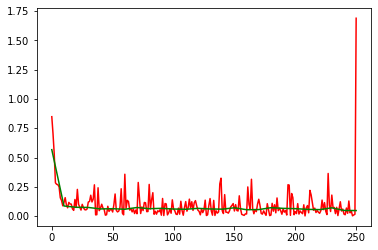

In [19]:
plt.plot(trainloss,c="r")
plt.plot(list(range(0,251,10)),validationloss,c='g')

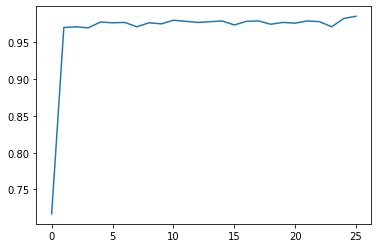

In [20]:
plt.plot(vaccuracy)

In [21]:
#model 2 monkey species
imgloader=datasets.ImageFolder("../input/10-monkey-species/training/training/",transform=transform)
validimgloader=datasets.ImageFolder("../input/10-monkey-species/validation/validation/",transform=transform)

In [22]:
dataloader = torch.utils.data.DataLoader(imgloader, batch_size=32, shuffle=True)
validdataloader = torch.utils.data.DataLoader(validimgloader, batch_size=32, shuffle=True)

In [23]:
model2=newmodel(10)
opt=op.Adam(model2.parameters(),lr=0.0001)
model2=model2.to(device)

In [24]:
trainloss=[]
validationloss=[]
vaccuracy=[]
c=0
for i in tqdm.tqdm(dataloader):
    opt.zero_grad()
    pred=model2(i[0].to(device))
    loss=f.cross_entropy(pred,i[1].to(device))
    loss.backward()
    opt.step()
    trainloss.append(loss.detach().cpu().item())
    print(loss)
    
    if c%10==0:
        print("---------validation_start-----------")
        model2.eval()
        with torch.no_grad():
            j=0
            validloss=[]
            vpred=[]
            vactual=[]
            for m in validdataloader:
                valpred=model2(m[0].to(device))
                vloss=f.cross_entropy(valpred,m[1].to(device))
                validloss.append(vloss.detach().cpu().item())
                vpred.append(valpred.detach().cpu().argmax(-1).numpy())
                vactual.append(m[1].detach().cpu().numpy())
            validationloss.append(sum(validloss)/len(validloss))
            vaccuracy.append(accuracy_score(np.concatenate(vpred),np.concatenate(vactual)))
            del valpred,vloss,vactual
            torch.cuda.empty_cache()
            print("-----------validation_end--------------")
            print("---loss---- ",validationloss[-1])
            print("---validacc---- ",vaccuracy[-1])
        model2.train()
    c+=1

  0%|          | 0/35 [00:00<?, ?it/s]

tensor(2.5040, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


  3%|▎         | 1/35 [00:16<09:07, 16.10s/it]

-----------validation_end--------------
---loss----  2.401904265085856
---validacc----  0.1213235294117647


  6%|▌         | 2/35 [00:18<04:27,  8.11s/it]

tensor(2.4003, device='cuda:0', grad_fn=<NllLossBackward>)


  9%|▊         | 3/35 [00:21<03:00,  5.65s/it]

tensor(2.2616, device='cuda:0', grad_fn=<NllLossBackward>)


 11%|█▏        | 4/35 [00:22<02:01,  3.93s/it]

tensor(2.1127, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 5/35 [00:23<01:29,  2.99s/it]

tensor(1.8826, device='cuda:0', grad_fn=<NllLossBackward>)


 17%|█▋        | 6/35 [00:25<01:12,  2.50s/it]

tensor(1.8681, device='cuda:0', grad_fn=<NllLossBackward>)


 20%|██        | 7/35 [00:27<01:02,  2.22s/it]

tensor(1.7102, device='cuda:0', grad_fn=<NllLossBackward>)


 23%|██▎       | 8/35 [00:28<00:53,  1.99s/it]

tensor(1.5183, device='cuda:0', grad_fn=<NllLossBackward>)


 26%|██▌       | 9/35 [00:30<00:51,  1.97s/it]

tensor(1.3731, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▊       | 10/35 [00:32<00:50,  2.01s/it]

tensor(1.2481, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2685, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 31%|███▏      | 11/35 [00:43<01:49,  4.58s/it]

-----------validation_end--------------
---loss----  1.1227115591367085
---validacc----  0.7941176470588235


 34%|███▍      | 12/35 [00:44<01:20,  3.50s/it]

tensor(1.0425, device='cuda:0', grad_fn=<NllLossBackward>)


 37%|███▋      | 13/35 [00:45<01:01,  2.80s/it]

tensor(0.8633, device='cuda:0', grad_fn=<NllLossBackward>)


 40%|████      | 14/35 [00:46<00:46,  2.22s/it]

tensor(1.0538, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 15/35 [00:47<00:37,  1.90s/it]

tensor(1.0878, device='cuda:0', grad_fn=<NllLossBackward>)


 46%|████▌     | 16/35 [00:48<00:32,  1.73s/it]

tensor(0.9060, device='cuda:0', grad_fn=<NllLossBackward>)


 49%|████▊     | 17/35 [00:50<00:29,  1.62s/it]

tensor(0.7425, device='cuda:0', grad_fn=<NllLossBackward>)


 51%|█████▏    | 18/35 [00:51<00:25,  1.53s/it]

tensor(0.7681, device='cuda:0', grad_fn=<NllLossBackward>)


 54%|█████▍    | 19/35 [00:53<00:25,  1.57s/it]

tensor(0.6889, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 20/35 [00:54<00:24,  1.60s/it]

tensor(0.6109, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4533, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 60%|██████    | 21/35 [01:04<00:57,  4.13s/it]

-----------validation_end--------------
---loss----  0.4734315243032243
---validacc----  0.9264705882352942


 63%|██████▎   | 22/35 [01:07<00:47,  3.62s/it]

tensor(0.4747, device='cuda:0', grad_fn=<NllLossBackward>)


 66%|██████▌   | 23/35 [01:09<00:38,  3.24s/it]

tensor(0.4273, device='cuda:0', grad_fn=<NllLossBackward>)


 69%|██████▊   | 24/35 [01:10<00:28,  2.62s/it]

tensor(0.3884, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████▏  | 25/35 [01:12<00:23,  2.36s/it]

tensor(0.5149, device='cuda:0', grad_fn=<NllLossBackward>)


 74%|███████▍  | 26/35 [01:14<00:19,  2.14s/it]

tensor(0.4661, device='cuda:0', grad_fn=<NllLossBackward>)


 77%|███████▋  | 27/35 [01:15<00:14,  1.85s/it]

tensor(0.3666, device='cuda:0', grad_fn=<NllLossBackward>)


 80%|████████  | 28/35 [01:16<00:12,  1.80s/it]

tensor(0.3451, device='cuda:0', grad_fn=<NllLossBackward>)


 83%|████████▎ | 29/35 [01:18<00:10,  1.79s/it]

tensor(0.3448, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 30/35 [01:20<00:09,  1.80s/it]

tensor(0.4362, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2718, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 89%|████████▊ | 31/35 [01:30<00:17,  4.34s/it]

-----------validation_end--------------
---loss----  0.257911279797554
---validacc----  0.9595588235294118


 91%|█████████▏| 32/35 [01:32<00:11,  3.68s/it]

tensor(0.2487, device='cuda:0', grad_fn=<NllLossBackward>)


 94%|█████████▍| 33/35 [01:33<00:05,  2.88s/it]

tensor(0.2456, device='cuda:0', grad_fn=<NllLossBackward>)


 97%|█████████▋| 34/35 [01:35<00:02,  2.35s/it]

tensor(0.2659, device='cuda:0', grad_fn=<NllLossBackward>)


100%|██████████| 35/35 [01:35<00:00,  2.72s/it]

tensor(0.7488, device='cuda:0', grad_fn=<NllLossBackward>)


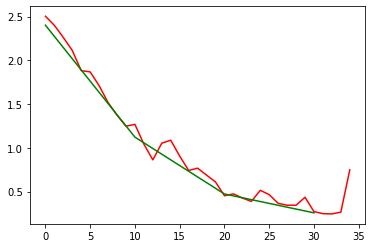

In [25]:
plt.plot(trainloss,c="r")
plt.plot(list(range(0,35,10)),validationloss,c='g')

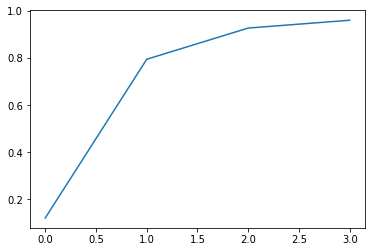

In [26]:
plt.plot(vaccuracy)

In [74]:
imgloader=datasets.ImageFolder("../input/cat-and-dog/training_set/training_set/",transform=transform)
validimgloader=datasets.ImageFolder("../input/cat-and-dog/test_set/test_set/",transform=transform)
dataloader = torch.utils.data.DataLoader(imgloader, batch_size=32, shuffle=True)
validdataloader = torch.utils.data.DataLoader(validimgloader, batch_size=32, shuffle=True)

In [75]:
#model 2 monkey species
imgloader1=datasets.ImageFolder("../input/10-monkey-species/training/training/",transform=transform)
validimgloader1=datasets.ImageFolder("../input/10-monkey-species/validation/validation/",transform=transform)
dataloader1 = torch.utils.data.DataLoader(imgloader1, batch_size=32, shuffle=True)
validdataloader1 = torch.utils.data.DataLoader(validimgloader1, batch_size=32, shuffle=True)

In [76]:
model3=distillmodel([2,10])

In [77]:
opt3=op.Adam(model3.parameters(),lr=0.001)

In [78]:
iter1=iter(dataloader)
iter2=iter(dataloader1)

In [79]:
model3=model3.to(device)

In [80]:
tau=5

In [81]:
def distill_loss(t,p):
    teacherprob=f.softmax(t/tau,dim=1)
    loss=torch.mean(torch.sum(-1*teacherprob*(f.log_softmax(p/tau,dim=1)),1))
    return loss

In [82]:
trainloss1=[]
trainloss2=[]
validationloss=[]
vaccuracy=[]
c=0
while True:
    i=next(iter1)
    j=next(iter2)
    if i is None or j is None:
        break
    opt3.zero_grad()
    
    #first 2 classes
    pred=model3(i[0].to(device),c=0)
    teacher=model1(i[0].to(device)).detach()
    loss1=distill_loss(teacher,pred)
    
    # first 10 classes
    pred1=model3(j[0].to(device),c=1)
    teacher1=model2(j[0].to(device)).detach()
    loss2=distill_loss(teacher1,pred1)
    
    tloss=loss1+loss2
    tloss.backward()
    opt3.step()
    trainloss1.append(loss1.detach().cpu().item())
    trainloss2.append(loss2.detach().cpu().item())
    c+=1
    print(c)
    if c==33:
        break
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


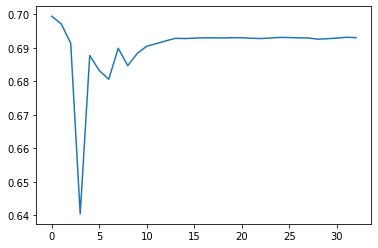

In [83]:
plt.plot(trainloss1)

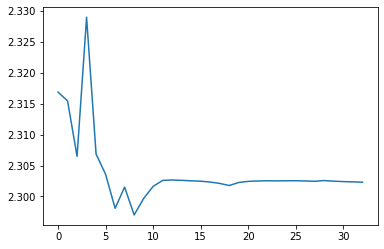

In [84]:
plt.plot(trainloss2)

In [85]:
model3.eval()
with torch.no_grad():
    j=0
    validloss=[]
    vpred=[]
    vactual=[]
    for m in validdataloader:
        valpred=model3(m[0].to(device),0)
        vloss=f.cross_entropy(valpred,m[1].to(device))
        validloss.append(vloss.detach().cpu().item())
        vpred.append(valpred.detach().cpu().argmax(-1).numpy())
        vactual.append(m[1].detach().cpu().numpy())
#     validationloss.append(sum(validloss)/len(validloss))
#     vaccuracy.append(accuracy_score(np.concatenate(vpred),np.concatenate(vactual)))
#     del valpred,vloss,vactual
#     torch.cuda.empty_cache()
#     print("-----------validation_end--------------")
#     print("---loss---- ",validationloss[-1])
#     print("---validacc---- ",vaccuracy[-1])

In [86]:
accuracy_score(np.concatenate(vpred),np.concatenate(vactual))

0.49975284231339595

In [87]:
model3.eval()
with torch.no_grad():
    j=0
    validloss=[]
    vpred=[]
    vactual=[]
    for m in validdataloader1:
        valpred=model3(m[0].to(device),1)
        vloss=f.cross_entropy(valpred,m[1].to(device))
        validloss.append(vloss.detach().cpu().item())
        vpred.append(valpred.detach().cpu().argmax(-1).numpy())
        vactual.append(m[1].detach().cpu().numpy())

In [88]:
accuracy_score(np.concatenate(vpred),np.concatenate(vactual))

0.09558823529411764